In [5]:
import networkx as nx
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch import nn
from collections import OrderedDict

In [1]:
import dgl
from data.data import LoadData


class DotDict(dict):
    def __init__(self, **kwds):
        self.update(kwds)
        self.__dict__ = self


In [9]:
# model = torch.load('out/SBMs_node_classification/checkpoints/GAT_SBM_CLUSTER_a8_GPU2_08h05m22s_on_May_03_2020/RUN_/epoch_69.pkl')
# embedding_table = model['embedding_h.weight']
# print(embedding_table)


tensor([[-0.1522, -0.1458,  0.3220,  ..., -0.2833, -0.6174,  1.6967],
        [-1.9800, -1.1799,  0.8276,  ..., -0.3010, -0.7653,  1.7106],
        [ 0.1535, -0.4368,  0.4580,  ..., -0.8300, -1.0034,  0.1282],
        ...,
        [ 0.8557,  1.9749,  0.0585,  ..., -0.8573, -0.5939, -0.0754],
        [ 1.2725,  0.7688,  0.7435,  ...,  0.0567, -0.9191, -0.4316],
        [-0.1134, -0.2709, -0.8935,  ...,  0.3223, -1.1869,  0.1937]],
       device='cuda:0')


In [31]:
# def get_values_statistics(DATASET_NAME):
#     dataset = LoadData(DATASET_NAME)
#     train, test, val = dataset.train, dataset.test, dataset.val
#     xe = []
#     K_list = []
#     feat_diff_list = []
#     for data in train.dataset:
#         W = data['W']
#         g_nx = nx.from_numpy_matrix(W.data.numpy())
#         edges = g_nx.edges
#         for u, v in edges:
#             node_label = data['node_label']
#             u_label = node_label[u]
#             v_label = node_label[v]
#             loss = (- torch.sum(v_label * torch.log(u_label)))
#             loss = loss.sum(dim=0)
#             node_feat = data['node_feat']
#             u_feat = embedding_table[node_feat[u].item()]
#             v_feat = embedding_table[node_feat[v].item()]
#             feat_sub = torch.sum(torch.abs(u_feat.sub(v_feat))).to(float).item()
#             feat_diff_list.append(feat_sub)
#             K = torch.abs(loss).float()/torch.norm((u_feat-v_feat).float(),2).float().item()
#             xe.append(loss.item())
#             K_list.append(K)  
#     return xe, K_list, feat_diff_list
# 
# DATASET_NAME_LIST = ['SBM_CLUSTER_SAMPLE_a8', 'SBM_CLUSTER_7', 'SBM_CLUSTER_a9']
# xe, K_list, feat_diff_list = get_values_statistics(DATASET_NAME_LIST[0])

[I] Loading dataset SBM_CLUSTER_SAMPLE_a8...
C:\Users\user\Desktop\project\benchmarking_gnns
train, test, val sizes : 100 10 10
[I] Finished loading.
[I] Data load time: 0.1705s


In [ ]:
# feat_max = int(np.max(feat_diff_list))
# feat_range = [x for x in range(0, feat_max, 1)]
# 
# def draw(xe, ed):
#     fig=plt.figure()
#     ax=fig.add_axes([0,0,1,1])
#     ax.scatter(feat_diff_list,xe , color='r')
#     ax.scatter(feat_diff_list, , color='b')
    # ax.set_xlabel('Difference between feature u and v')
    # ax.set_ylabel('Cross entropy')
    # ax.set_title('scatter plot')
    # plt.show()
#         
# draw(xe, feat_diff_list)
        

In [2]:
dataset_cluster_a8 = LoadData('SBM_CLUSTER_a8')
dataset_cluster = LoadData('SBM_CLUSTER')

[I] Loading dataset SBM_CLUSTER_a8...
C:\Users\user\Desktop\project\benchmarking_gnns
train, test, val sizes : 10000 1000 1000
[I] Finished loading.
[I] Data load time: 21.4536s
[I] Loading dataset SBM_CLUSTER...
train, test, val sizes : 10000 1000 1000
[I] Finished loading.
[I] Data load time: 22.4500s


In [7]:
# edge_idx 0 is any edge
def get_xe_losses(dataset):
    edges_idx_dict = OrderedDict()
    idx = 0
    xe_losses = []
    train, test, val = dataset.train, dataset.test, dataset.val

    for w_idx, data in enumerate(train.dataset):
        xe_losses.append(0)
        W = data['W']
        g_nx = nx.from_numpy_matrix(W.data.numpy())
        edges = g_nx.edges
        for u, v in edges:
            if str(u)+"_"+str(v) +"_" + str(w_idx) in edges_idx_dict.keys():
                continue
            edges_idx_dict[str(u)+"_"+str(v)+"_"+str(w_idx)] = idx
            idx+=1
            
            node_label = data['node_label']
            u_label = node_label[u].to(float)
            v_label = node_label[v].to(float)
            
            loss = (- torch.sum(v_label * torch.log(u_label)))
            loss = loss.sum(dim=0)
            xe_losses[w_idx] += loss.item()
    # idx_edge_dict = OrderedDict()
    # for k,v in edges_idx_dict.items():
    #     idx_edge_dict[v] = k
    # sorted_idx = np.argmax(xe_losses)
    # sorted_xe_list = sorted(xe_losses) 
    
    # sorted_edge_dict = OrderedDict()
    # for idx in sorted_idx:
    #     sorted_edge_dict[edges_idx_dict[idx]]= idx
    #TODO sorting XE, edges
    # return sorted_xe_list, edges_idx_dict, sorted_edge_dict
    return xe_losses, edges_idx_dict

In [ ]:
xe_losses, edges_idx_dict = get_xe_losses(dataset_cluster)
#TODO get XE by using edges_list

In [ ]:
def get_max_diff_losses_btw_original_and_smooth(dataset, xe_losses, edges_idx_dict):
    train, test, val = dataset.train, dataset.test, dataset.val
    edge_idx_list = []
    max_loss = 0
    max_loss_idx = 0
    for w_idx, data in enumerate(train.dataset):
        W = data['W']
        g_nx = nx.from_numpy_matrix(W.data.numpy())
        edges = g_nx.edges
        losses = 0
        for u, v in edges:
            edge_idx = 0
            key_edge = str(u)+"_"+str(v) +"_"+str(w_idx)
            if key_edge in edges_idx_dict.keys():
                edge_idx = edges_idx_dict[key_edge]
            edge_idx_list.append(edge_idx)
            
            node_label = data['node_label']
            u_label = node_label[u].to(float)
            v_label = node_label[v].to(float)
            
            loss = (- torch.sum(v_label * torch.log(u_label)))
            loss = loss.sum(dim=0)
            losses += loss
        
        diff_loss = xe_losses[w_idx] - losses
        if diff_loss < max_loss:
            max_loss_idx = w_idx
            max_loss = diff_loss
            
    max_W = train.dataset[max_loss_idx]['W']
    g_nx = nx.from_numpy_matrix(max_W.data.numpy())
    max_edges = g_nx.edges
    
    smoothed_losses = []
    for u, v in max_edges:
        node_label = data['node_label']
        u_label = node_label[u].to(float)
        v_label = node_label[v].to(float)
            
        loss = (- torch.sum(v_label * torch.log(u_label)))
        loss = loss.sum(dim=0)
        smoothed_losses.append(loss)
    
    # sorted_xe_list = sorted(cross_entropy_loesses, key=lambda k: edge_idx_list)
    return max_edges, smoothed_losses, xe_losses[w_idx]

In [ ]:
max_edges, smoothed_losses, max_original_losses = get_max_diff_losses_btw_original_and_smooth(dataset_cluster_a8, sorted_edge_dict)
# edge_dict_cluster = get_edges('SBM_PATTERN')

In [49]:
# def get_values_statistics(dataset, edge_dict):
#     train, test, val = dataset.train, dataset.test, dataset.val
#     xe = []
#     edge_idx_list = []
#     for w_idx, data in enumerate(train.dataset):
#         W = data['W']
#         g_nx = nx.from_numpy_matrix(W.data.numpy())
#         edges = g_nx.edges
#         for u, v in edges:
#             edge_idx = 0
# 
#             key_edge = str(u)+"_"+str(v) +"_"+str(w_idx)
#             if key_edge in edge_dict.keys():
#                 edge_idx = edge_dict[key_edge]
#             edge_idx_list.append(edge_idx)
#             
#             node_label = data['node_label']
#             u_label = node_label[u].to(float)
#             v_label = node_label[v].to(float)
#             
#             loss = (- torch.sum(v_label * torch.log(u_label)))
#             loss = loss.sum(dim=0)
#             xe.append(loss.item())
#     return xe, edge_idx_list
# 
# DATASET_NAME_LIST = ['SBM_CLUSTER', 'SBM_CLUSTER_a8']
# sorted_xe_list, edge_idx_list= get_values_statistics(edge_dict_cluster, edge_dict_cluster)
# xe2, edge_idx_list2= get_values_statistics(edge_dict_cluster_a8, edge_dict_cluster_a8)

[I] Loading dataset SBM_CLUSTER...
train, test, val sizes : 10000 1000 1000
[I] Finished loading.
[I] Data load time: 35.9160s
[I] Loading dataset SBM_CLUSTER_a8...
C:\Users\user\Desktop\project\benchmarking_gnns
train, test, val sizes : 10000 1000 1000
[I] Finished loading.
[I] Data load time: 113.0859s


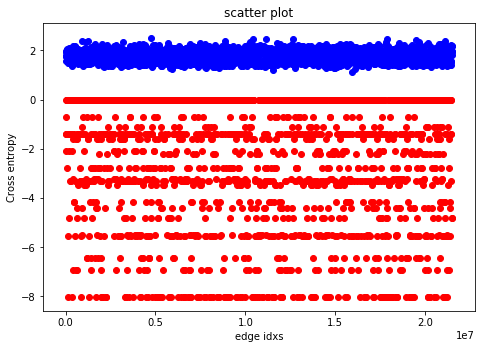

In [50]:
def draw(xe, edge_idx_list, xe2, edge_idx_list2):
    fig=plt.figure()
    ax=fig.add_axes([0,0,1,1])
    ax.scatter(edge_idx_list, xe , color='r')
    ax.scatter(edge_idx_list2, xe2, color='b')
    ax.set_xlabel('edge idxs')
    ax.set_ylabel('Cross entropy')
    ax.set_title('scatter plot')
    plt.show()

In [ ]:
# def draw(xe, edge_idx_list, xe2, edge_idx_list2):
#     fig=plt.figure()
#     ax=fig.add_axes([0,0,1,1])
#     ax.scatter(edge_idx_list, xe , color='r')
#     ax.scatter(edge_idx_list2, xe2, color='b')
#     ax.set_xlabel('edge idxs')
#     ax.set_ylabel('Cross entropy')
#     ax.set_title('scatter plot')
#     plt.show()
#         
draw(smoothed_losses, max_edges, smoothed_losses, max_edges)



In [39]:
print(len(edge_idx_list))







220607


NameError: name 'nx' is not defined